In [1]:
# Using the historical price of a stock as a predictor of its own prices

In [2]:
# Data Preparation

In [22]:
# Imports

import yfinance as yf
import numpy as np
import pandas as pd
import hvplot.pandas

In [23]:
# Load price data for BRK-B using yfinance
df = yf.download("BRK-B", start='2019-01-01', end='2021-05-31')
df = df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'BRK-B'})
df.head()

[*********************100%***********************]  1 of 1 completed


,BRK-B
Date,
2019-01-02,202.800003
2019-01-03,191.660004
2019-01-04,195.199997
2019-01-07,196.910004
2019-01-08,196.309998


In [24]:
# Below function takes column number for the features (X) and target (y)
# It accumulates the data with a rolling window of X(t-n) to predict Xt
# Finally, it returns a numpy array of X and y

def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [25]:
# Predict Closing Prices using a 10 day window of previous closing prices

window_size = 30

# Column index 0 is the 'index' column
# Column index 1 is the 'stock' column
feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [26]:
# 70% of data will be for training and 30% for testing

from sklearn.model_selection import train_test_split
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [27]:
# Scaling data between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [28]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [29]:
## Building/training LSTM RNN

In [30]:
# Imports from tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [31]:
# LSTM Model
# How many layers are we doing? Check before doing return sequences. Set to True if adding more LSTM layers but not for final layer
# Input shape: number of time steps and number of indicators
# Dropouts to prevent overfitting
# Define the LSTM RNN model

model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer

model.add(Dense(1))

In [32]:
# Compile the model

model.compile(optimizer="adam", loss="mean_squared_error")

In [33]:
# Summarize the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [34]:
# Train the model

model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=1, verbose=1)

Epoch 1/50
403/403 [==============================] - 11s 17ms/step - loss: 0.0087
Epoch 2/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0035
Epoch 3/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0039
Epoch 4/50
403/403 [==============================] - 6s 16ms/step - loss: 0.0049
Epoch 5/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0040
Epoch 6/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0036
Epoch 7/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0035
Epoch 8/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0031
Epoch 9/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0029
Epoch 10/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0026: 0s 
Epoch 11/50
403/403 [==============================] - 7s 16ms/step - loss: 0.0023
Epoch 12/50
403/403 [==============================] - 6s 16ms/step - loss: 0.0022
Epoch 1

In [16]:
## Model Performance

In [17]:
# Evaluate the model

model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 11ms/step - loss: 0.1383


0.13833121955394745

In [18]:
# Predictions

predicted = model.predict(X_test)

In [19]:
# Recover the unscaled prices

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create df of predicted and real prices

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-09-21,213.020004,199.655426
2020-09-22,214.160004,199.655426
2020-09-23,209.610001,199.655426
2020-09-24,208.720001,199.655426
2020-09-25,210.449997,199.655426



Bad key "text.kerning_factor" on line 4 in
C:\Users\prisc\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


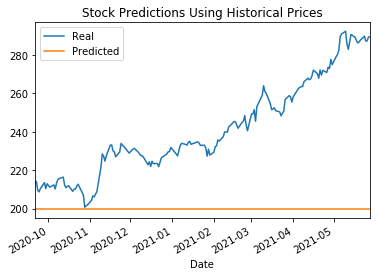

In [21]:
# Real vs predicted line plot to check fit

stocks.plot(title="Stock Predictions Using Historical Prices")